Following the numpy tutorial: <br>
### [Linear algebra on n-dimensional arrays](https://numpy.org/numpy-tutorials/content/tutorial-svd.html)

In [26]:
from scipy.datasets import face

img = face()
type(img)

numpy.ndarray

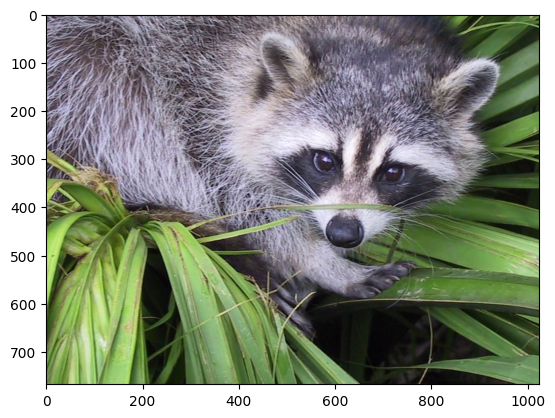

In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img)
plt.show()

In [28]:
img.shape

(768, 1024, 3)

The tutorial explains "The output is a tuple with three elements, which means that this
is a three-dimensional array. In fact, since this is a color image, and we have used the
imread function to read it, the data is organized in three 2D arrays, representing color
channels (in this case, red, green and blue - RGB). You can see this by looking at the
shape above: it indicates that we have an array of 3 matrices, each having shape
768x1024."

But after a lot of contemplating I am convinced that is wrong. In numpy, the leftmost
axis is the outermost. In shape (768, 1024, 3) the colour channels axis stands for the
innermost axis. So rather than "three matrices of shape 768x1024," I think it helps
building intuition better to talk about a 768x1024 grid of pixels, where each pixel has
3 values for RBG. I've [fixed this](https://github.com/numpy/numpy-tutorials/pull/260).

In [29]:
# here a visualisable example that is small enough to be printed_

import numpy as np

arr = np.ones(2*3*4).reshape(2,3,4)
arr

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [30]:
img[:, :, 0]

array([[121, 138, 153, ..., 119, 131, 139],
       [ 89, 110, 130, ..., 118, 134, 146],
       [ 73,  94, 115, ..., 117, 133, 144],
       ...,
       [ 87,  94, 107, ..., 120, 119, 119],
       [ 85,  95, 112, ..., 121, 120, 120],
       [ 85,  97, 111, ..., 120, 119, 118]],
      shape=(768, 1024), dtype=uint8)

In [31]:
# normalise for following linear algebra operations

img_array = img / 255

In [32]:
# inspecting the red channel
img_array[:, :, 0]

array([[0.4745098 , 0.54117647, 0.6       , ..., 0.46666667, 0.51372549,
        0.54509804],
       [0.34901961, 0.43137255, 0.50980392, ..., 0.4627451 , 0.5254902 ,
        0.57254902],
       [0.28627451, 0.36862745, 0.45098039, ..., 0.45882353, 0.52156863,
        0.56470588],
       ...,
       [0.34117647, 0.36862745, 0.41960784, ..., 0.47058824, 0.46666667,
        0.46666667],
       [0.33333333, 0.37254902, 0.43921569, ..., 0.4745098 , 0.47058824,
        0.47058824],
       [0.33333333, 0.38039216, 0.43529412, ..., 0.47058824, 0.46666667,
        0.4627451 ]], shape=(768, 1024))

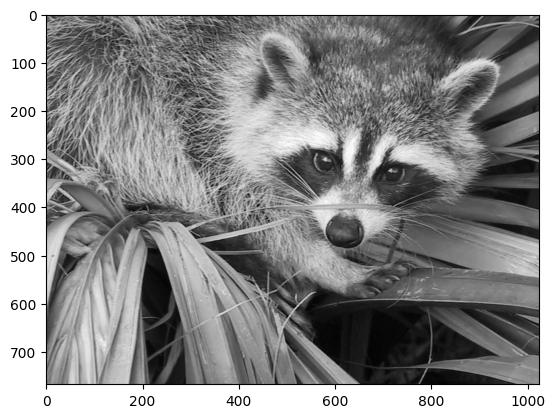

In [33]:
# obtaining grayscale image
img_gray = img_array @ [0.2126, 0.7152, 0.0722]

plt.imshow(img_gray, cmap="gray")
plt.show()

### SVD 
Use Singular Value Decomposition to try to rebuild an image that uses less singular
value information than the original one, while still retaining some of its features.

SVD decomposes `X` into three matrices:

$$ X=UΣV^T $$

- $U$ mxm matrix holding information on the variance of rows, 
- $Σ$ is a diagonal matrix that expresses the scale of the variances (than can be used
to select the principal components) 
- $V^T$ nxn matrix holding  information on the variance among columns

This [GeeksforGeeks SVD
Tutorial](https://www.geeksforgeeks.org/machine-learning/singular-value-decomposition-svd/?utm_source=chatgpt.com)
gives a bit more insight, it requires quite some math and stats knowledge though.

Jessica Gonzalez' [Linear Algebra
Tutorial](https://github.com/Jessica-go/lin_alg_1/blob/main/notebooks/04_regre_pca.ipynb)
offers insights of how SVD is used in the context of PCA and how it works
mathematically.

Both tutorials are a bit different: geekforgeeks show a pure SVD decomposition of A, not
necessarily connected to variance or PCA, Jessica shows a specific application of SVD,
which is PCA.

In [34]:
from numpy import linalg

U, s, Vt = linalg.svd(img_gray)

U.shape, s.shape, Vt.shape

((768, 768), (768,), (1024, 1024))

Here, $s$ is represented by numpy as a 1-D array, but mathematically it is a diagonal
matrix with 0 entries everywhere, except for the diagonal. The largest values are sorted to the beginning, which can be interpreted as importance.

In [35]:
s[:10]

array([410.42098224,  85.56090199,  63.61066707,  45.85114695,
        41.96884158,  38.25875097,  31.65941584,  27.22637539,
        26.52061638,  26.10815362])

In [36]:
s[-10:]

array([0.01215173, 0.01201027, 0.01164519, 0.01142034, 0.01127394,
       0.01117286, 0.01085116, 0.01079159, 0.01031601, 0.00992525])

In [37]:
# reconstructing sigma to use it in further computation
Sigma = np.zeros((U.shape[1], Vt.shape[0]))
np.fill_diagonal(Sigma, s)

Sigma.shape

(768, 1024)

In [38]:
# computing the norm of the original and the reconstructed matrix to see how different they are
linalg.norm(img_gray - U @ Sigma @ Vt)

np.float64(1.427492632807217e-12)

They are almost similar. The difference is due to floating point rounding errors and
depends on architecture and setup.

In [39]:
# alternative
np.allclose(img_gray, U @ Sigma @ Vt)

True

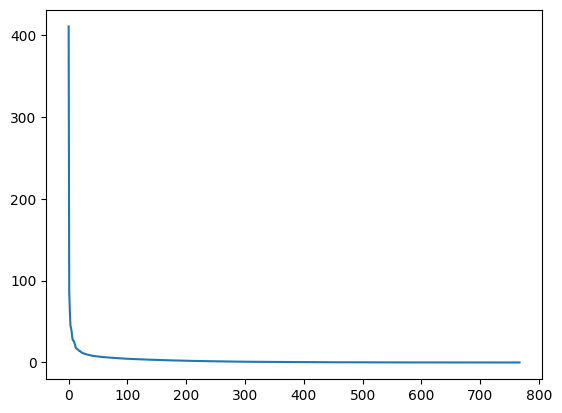

In [40]:
# check the values in s to see if an approximation is reasonable:
plt.plot(s)
plt.show()

The entries get small rather quickly. It makes sense to only use information on the first 50 or so entries to store this picture.

Now we consider all but the first k singular values in `Sigma` as zeros while keeping `U` and `Vt` intact and compute the product of these matrices as the approximation.

Norm:  94.34580122549066


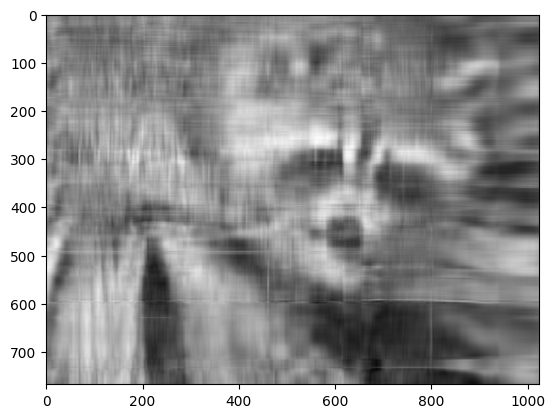

In [41]:
k = 10
# only consider first k columns of Sigma and first k rows on Vt (this changes their shapes)
approx = U @ Sigma[:, :k] @ Vt[:k, :]
print("Norm: ", linalg.norm(approx - U @ Sigma @ Vt))

plt.imshow(approx, cmap="gray")
plt.show()

Norm:  169.48195006093798


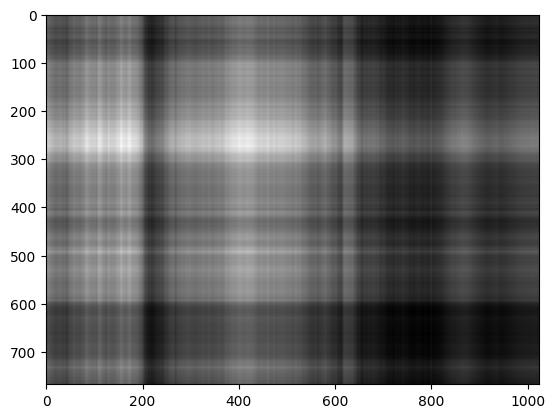

In [42]:
k = 1
# only consider first k columns of Sigma and first k rows on Vt (this changes their shapes)
approx = U @ Sigma[:, :k] @ Vt[:k, :]
print("Norm: ", linalg.norm(approx - U @ Sigma @ Vt))

plt.imshow(approx, cmap="gray")
plt.show()

Norm:  55.372370043870106


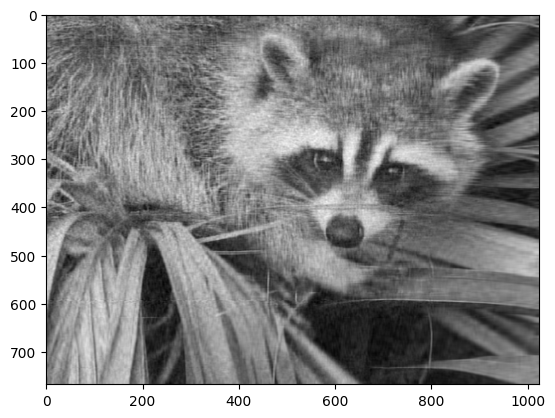

In [43]:
k = 50
# only consider first k columns of Sigma and first k rows on Vt (this changes their shapes)
approx = U @ Sigma[:, :k] @ Vt[:k, :]
print("Norm: ", linalg.norm(approx - U @ Sigma @ Vt))

plt.imshow(approx, cmap="gray")
plt.show()

Applying to all colours using broadcasting:

In [44]:
# transpose axes so that the color channel is the outer axis (the following operations
# expect this shape)
img_array_transposed = np.transpose(img_array, (2, 0, 1))
img_array_transposed.shape

(3, 768, 1024)

In [45]:
U, s, Vt = linalg.svd(img_array_transposed)
U.shape, s.shape, Vt.shape

((3, 768, 768), (3, 768), (3, 1024, 1024))

multiplication across different axes are facilitaed by broadcasting

In [46]:
# build Sigma with three diagonal elements
Sigma = np.zeros((3, 768, 1024))
for j in range(3):
    np.fill_diagonal(Sigma[j, :, :], s[j, :])

Sigma.shape

(3, 768, 1024)

In [47]:
reconstructed = U @ Sigma @ Vt

# clip to clip values to range [0,1] after probable floating point errors
reconstructed = np.clip(reconstructed, 0, 1)
reconstructed.shape

(3, 768, 1024)

Norm:  5.008361494133689e-14


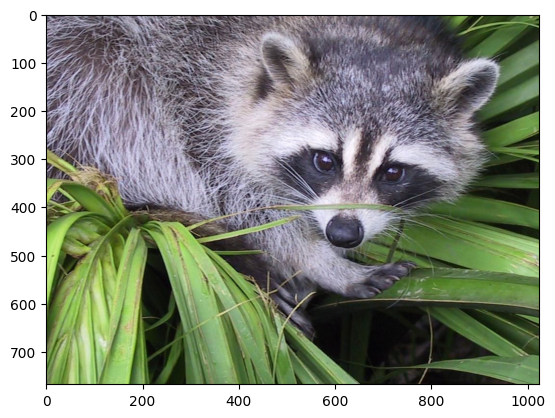

In [50]:
print("Norm: ",linalg.norm(reconstructed - U @ Sigma @ Vt))

plt.imshow(np.transpose(reconstructed, (1, 2, 0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0815199115002168..1.0872255910798903].


Norm:  130.68739646784456


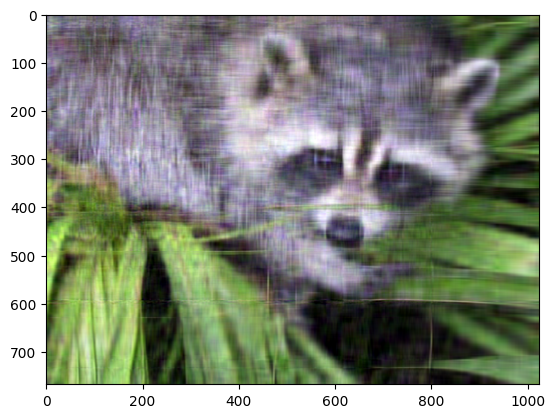

In [ ]:
# only keep k most important values

k = 20
approx_img = U @ Sigma[..., :k] @ Vt[..., :k, :] # see tutorial for explanation
print("Norm: ",linalg.norm(approx_img - U @ Sigma @ Vt))

plt.imshow(np.transpose(approx_img, (1, 2, 0)))
plt.show()

In [51]:
approx_img.shape

(3, 768, 1024)

SVD is a low-rank approximation for the original data.

It is a technique that measures how much variance each pattern (a combination of rows and columns) explains and then only keeps the most important patterns for the following re-construction via $A_k = U_k \, \Sigma_k \, V_k^{T}$.

When we drop the smaller singular values, we literally set them to 0 for the following
matrix multiplications, because this pattern doesn't contribute significantly enough.
This goes per colour channel.

### Tiny example

$$
A=\begin{bmatrix}3 & 2\\ 2 & 3\end{bmatrix}
$$

SVD gives (rounded):
$$
A= 
\begin{bmatrix}
\tfrac{1}{\sqrt{2}} & -\tfrac{1}{\sqrt{2}}\\
\tfrac{1}{\sqrt{2}} & \tfrac{1}{\sqrt{2}}
\end{bmatrix}
\begin{bmatrix}
5 & 0\\
0 & 1
\end{bmatrix}
\begin{bmatrix}
\tfrac{1}{\sqrt{2}} & \tfrac{1}{\sqrt{2}}\\
-\tfrac{1}{\sqrt{2}} & \tfrac{1}{\sqrt{2}}
\end{bmatrix}
$$

If we keep both singular values (5 and 1), we reconstruct the exact A.

If we drop the smaller one (1), so 
$$
\Sigma =
\begin{bmatrix}
5 & 0 \\
0 & 0
\end{bmatrix},
$$

then:

$$
\quad
A' \approx
\begin{bmatrix}
2.5 & 2.5 \\
2.5 & 2.5
\end{bmatrix}
$$

The new matrix is full, not zeros, but all entries are the same (lost detail).

This is approximation using only the strongest pattern.